# defaulting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 로깅 설정 (선택 사항, 진행 상황 및 경고 표시)
sc.settings.verbosity = 3             # verbosity: 3 = 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# loading

In [2]:
adata=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/downsampled_100_25-04-15-08-34.h5ad")
print(adata)
print(len(adata.var_names))
adata.var_names_make_unique()  # 중복된 유전자 이름 처리
print(len(adata.var_names))

AnnData object with n_obs × n_vars = 42649 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_ty

## QC metric calculation

In [26]:

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
# 이 스텝에서 n_genes_by_counts, total_counts 계산

## visualization

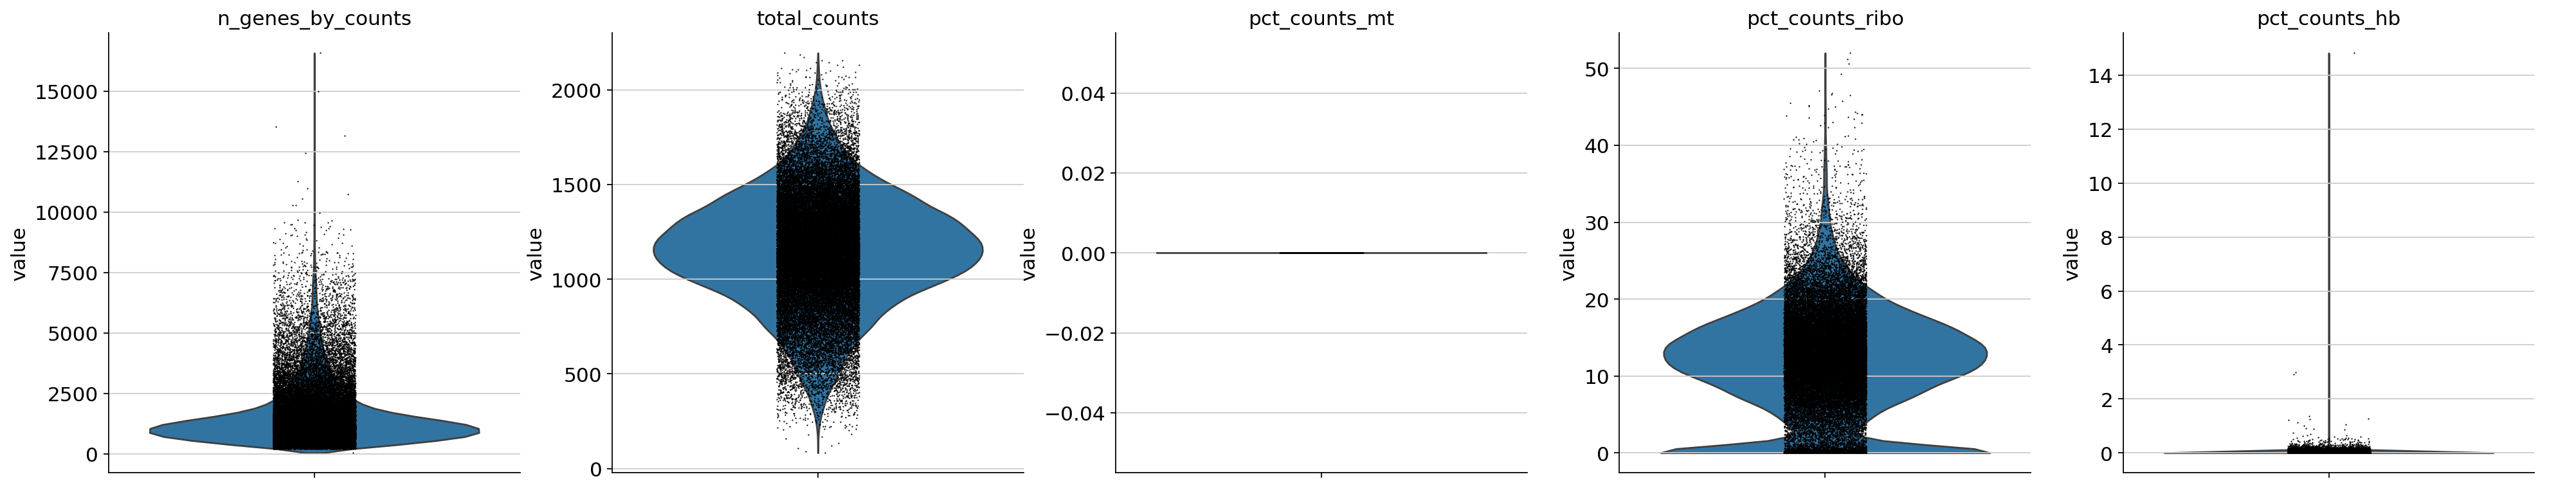

In [22]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.1,
    multi_panel=True,
)

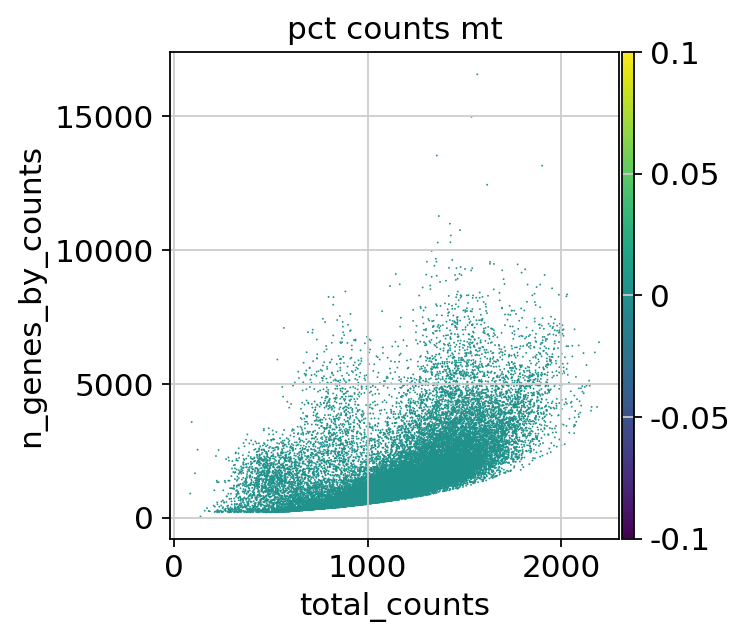

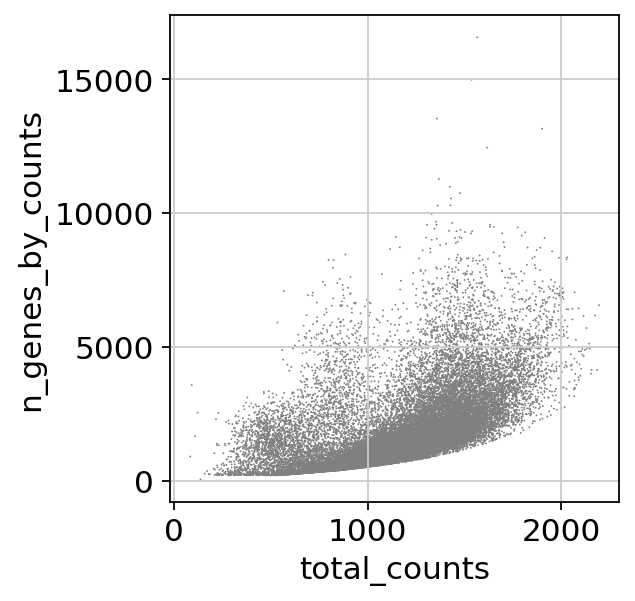

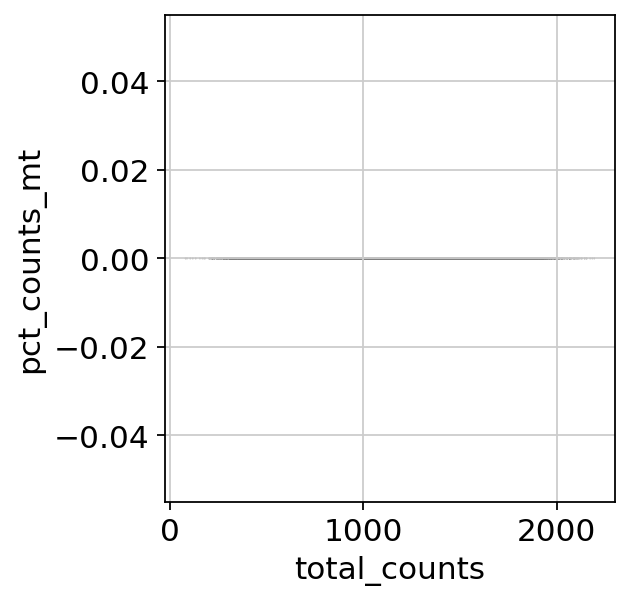

In [15]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=True)

## filtering

In [27]:
# 필터링 (값은 데이터셋에 따라 조절해야 함)
print(f"Original number of cells: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes=200) # 최소 200개 유전자 발현 세포만 유지
sc.pp.filter_genes(adata, min_cells=3)   # 최소 3개 세포에서 발현된 유전자만 유지

# 미토콘드리아 비율이 너무 높거나, 발현 유전자/counts 수가 너무 적거나 많은 세포 제거
# 이 임계값(threshold)은 데이터셋 특성에 맞춰 신중하게 결정해야 합니다.
# adata = adata[adata.obs.n_genes_by_counts < 2500, :] # 예시: 유전자 수 상한
adata = adata[adata.obs.pct_counts_mt < 5, :]        # 예시: 미토콘드리아 비율 상한
print(f"Number of cells after filtering: {adata.n_obs}")

Original number of cells: 42649
filtered out 1 cells that have less than 200 genes expressed
filtered out 2280 genes that are detected in less than 3 cells
Number of cells after filtering: 42648


## fork

In [28]:
adata_origin=adata

# preprocessing

## NMZ

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


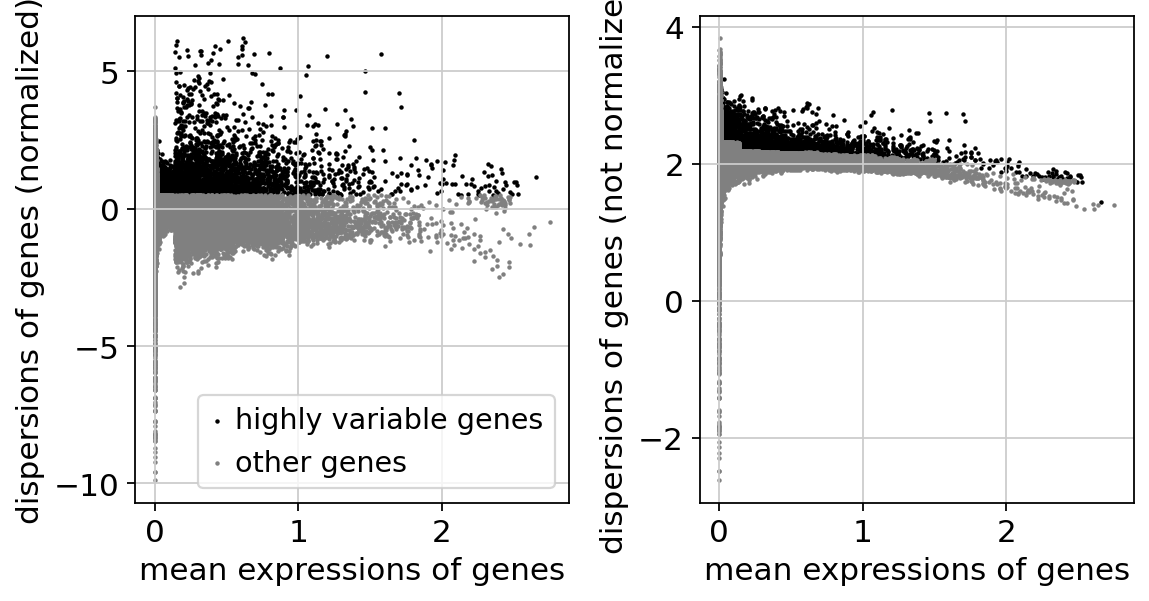

/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [30]:
adata=adata_origin
# --- 2단계: 정규화 (Normalization) ---
# 각 세포의 라이브러리 크기(총 counts)를 동일하게 조정 (예: 10,000)
sc.pp.normalize_total(adata, target_sum=1e4)

# 로그 변환 (데이터 분포 안정화 및 분산 안정화)
sc.pp.log1p(adata)

# --- 3단계: 고분산 유전자 선택 (Highly Variable Genes, HVGs) ---
# 생물학적으로 의미 있는 변화를 보이는 유전자 식별
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, show=True)

# 분석에 HVG만 사용하도록 설정 (실제 데이터 필터링은 나중에)
adata.raw = adata # 원본 데이터(정규화 및 로그 변환됨)를 .raw에 저장
adata = adata[:, adata.var.highly_variable] # HVG만 선택하여 adata 업데이트

# --- 4단계: 스케일링 (Scaling) ---
# 각 유전자의 발현값을 평균 0, 분산 1이 되도록 조정
# PCA와 같은 차원 축소 전에 수행
sc.pp.scale(adata, max_value=10) # 발현값이 10을 초과하는 경우 10으로 제한(clipping)

### SCT

In [ ]:
import sctransform

# --- 가정: adata는 초기 로딩 및 QC 필터링(세포/유전자 제거)까지만 완료됨 ---
# --- 즉, adata.X는 필터링된 raw count 상태여야 함 ---
adata=adata_origin
# 예시 QC 완료 상태의 adata
# (이전 답변의 1. 데이터 로딩 및 메타데이터 추가, 2. 품질 관리 부분 실행 완료 가정)
# print("AnnData object after QC filtering:")
# print(adata) # 이 시점의 adata.X는 raw counts

# --- SCTransform 적용 ---
# SCTransform은 scipy sparse matrix를 입력으로 받음
counts_matrix = adata.X.copy()

# SCTransform 실행 (vst: variance stabilizing transformation)
# cell_attr, gene_attr로 obs, var 데이터프레임 전달 가능
vst_out = sctransform.vst(
    counts_matrix,
    gene_names=adata.var_names.tolist(),
    cell_names=adata.obs_names.tolist(),
    method='poisson', # 또는 'nb'
    n_genes=3000,     # 식별할 HVG 수 (조정 가능)
    min_cells=5,      # 유전자가 최소 이 수의 세포에서 발현되어야 고려
    residual_type='pearson', # pearson 잔차를 주로 사용
    verbosity=1
)

# SCTransform 결과는 딕셔너리 형태
# print(vst_out.keys())
# dict_keys(['residuals', 'corrected_counts', 'model_pars', 'model_pars_fit', 'gene_attr', 'cell_attr'])

# 결과를 AnnData 객체에 저장
# 1. 잔차(Residuals): PCA 등 다운스트림 분석에 주로 사용됨
adata.layers['sct_residuals'] = vst_out['residuals']

# 2. 보정된 Count (선택적): 시각화 등에 사용 가능
adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']

# 3. 식별된 고변동 유전자 정보 저장
# vst_out['gene_attr'] 데이터프레임에 HVG 정보가 있음 ('highly_variable' 컬럼)
adata.var = adata.var.join(vst_out['gene_attr'].set_index('gene_name'), how='left')
adata.var.rename(columns={'residual_variance': 'sct_residual_variance'}, inplace=True) # 이름 충돌 방지

# HVG로 플래그 지정 (sctransform > 0.1.0 기준, highly_variable 컬럼 존재)
if 'highly_variable' in adata.var.columns:
     adata.var['highly_variable'] = adata.var['highly_variable'].fillna(False)
     print(f"Identified {adata.var['highly_variable'].sum()} HVGs using SCTransform.")
else:
    # 이전 버전 호환성 또는 다른 기준 적용 필요시:
    # 예: 상위 N개 유전자를 HVG로 설정 (n_genes 파라미터 기준)
    hvg_genes = vst_out['gene_attr'].sort_values('residual_variance', ascending=False).head(3000)['gene_name'].tolist() # 예시
    adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
    print(f"Flagged top {len(hvg_genes)} genes as HVGs based on SCTransform residual variance.")


## PCA, clustering

computing PCA
    with n_comps=50
    finished (0:00:10)


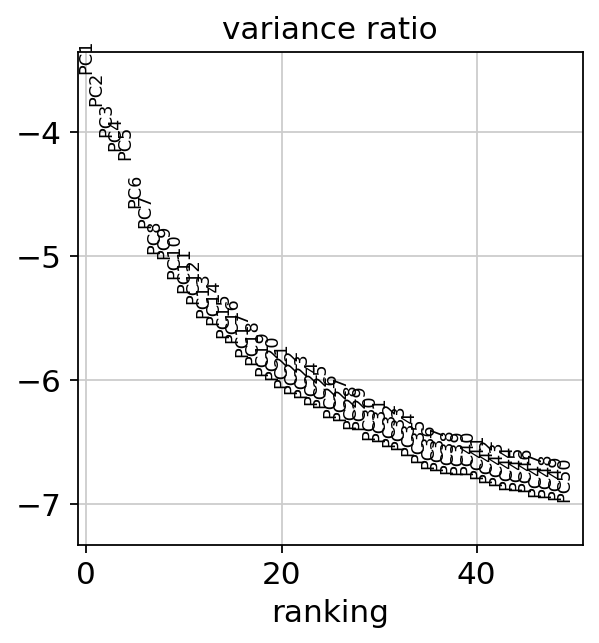

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
running Leiden clustering


/tmp/ipykernel_4186204/1205320919.py:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8)


    finished: found 44 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)


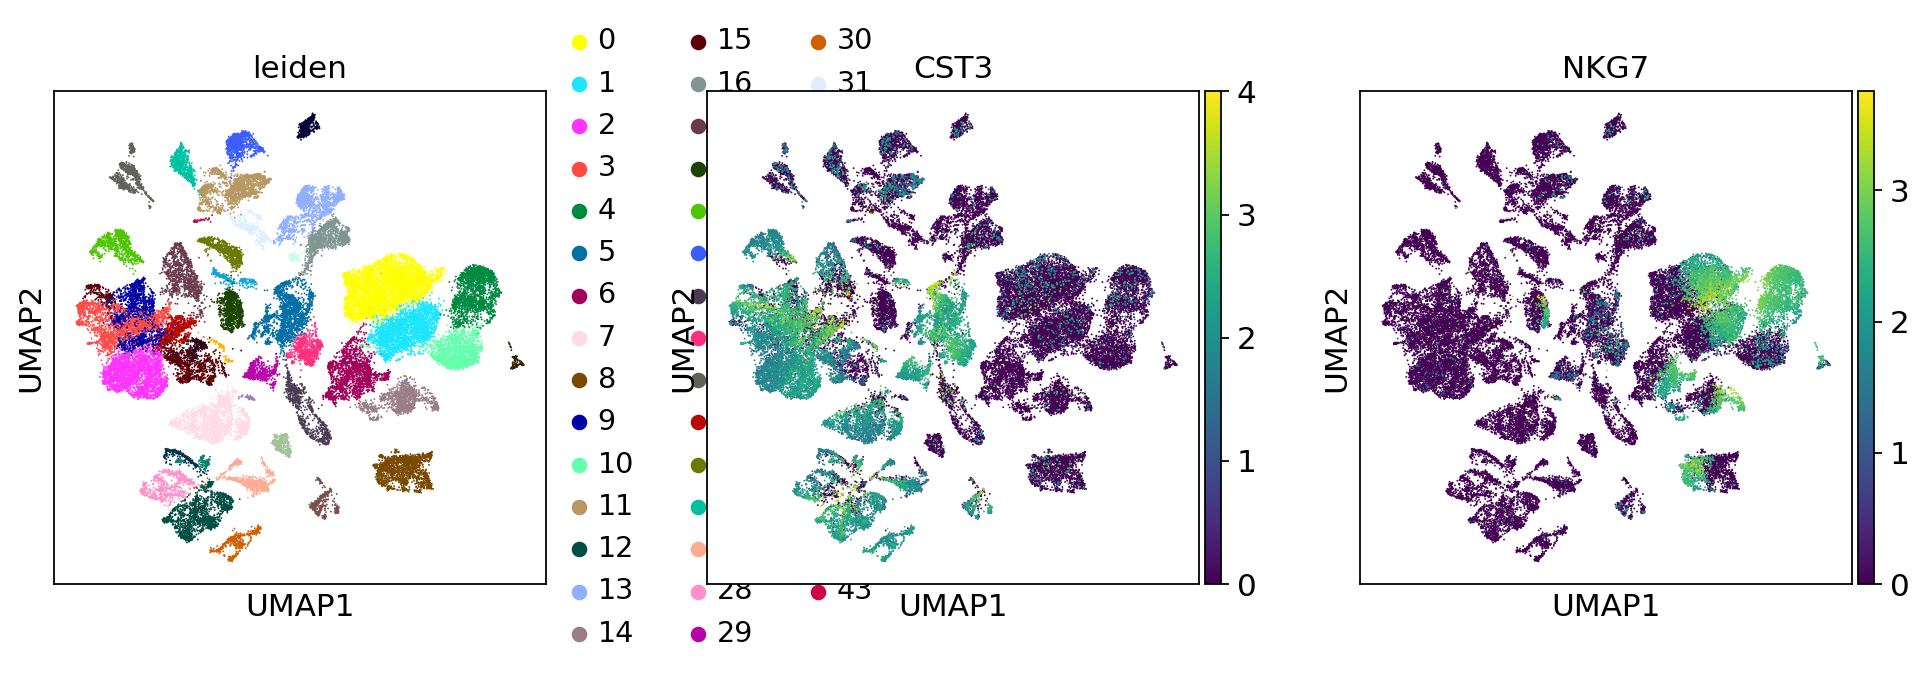

ranking genes


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:10)


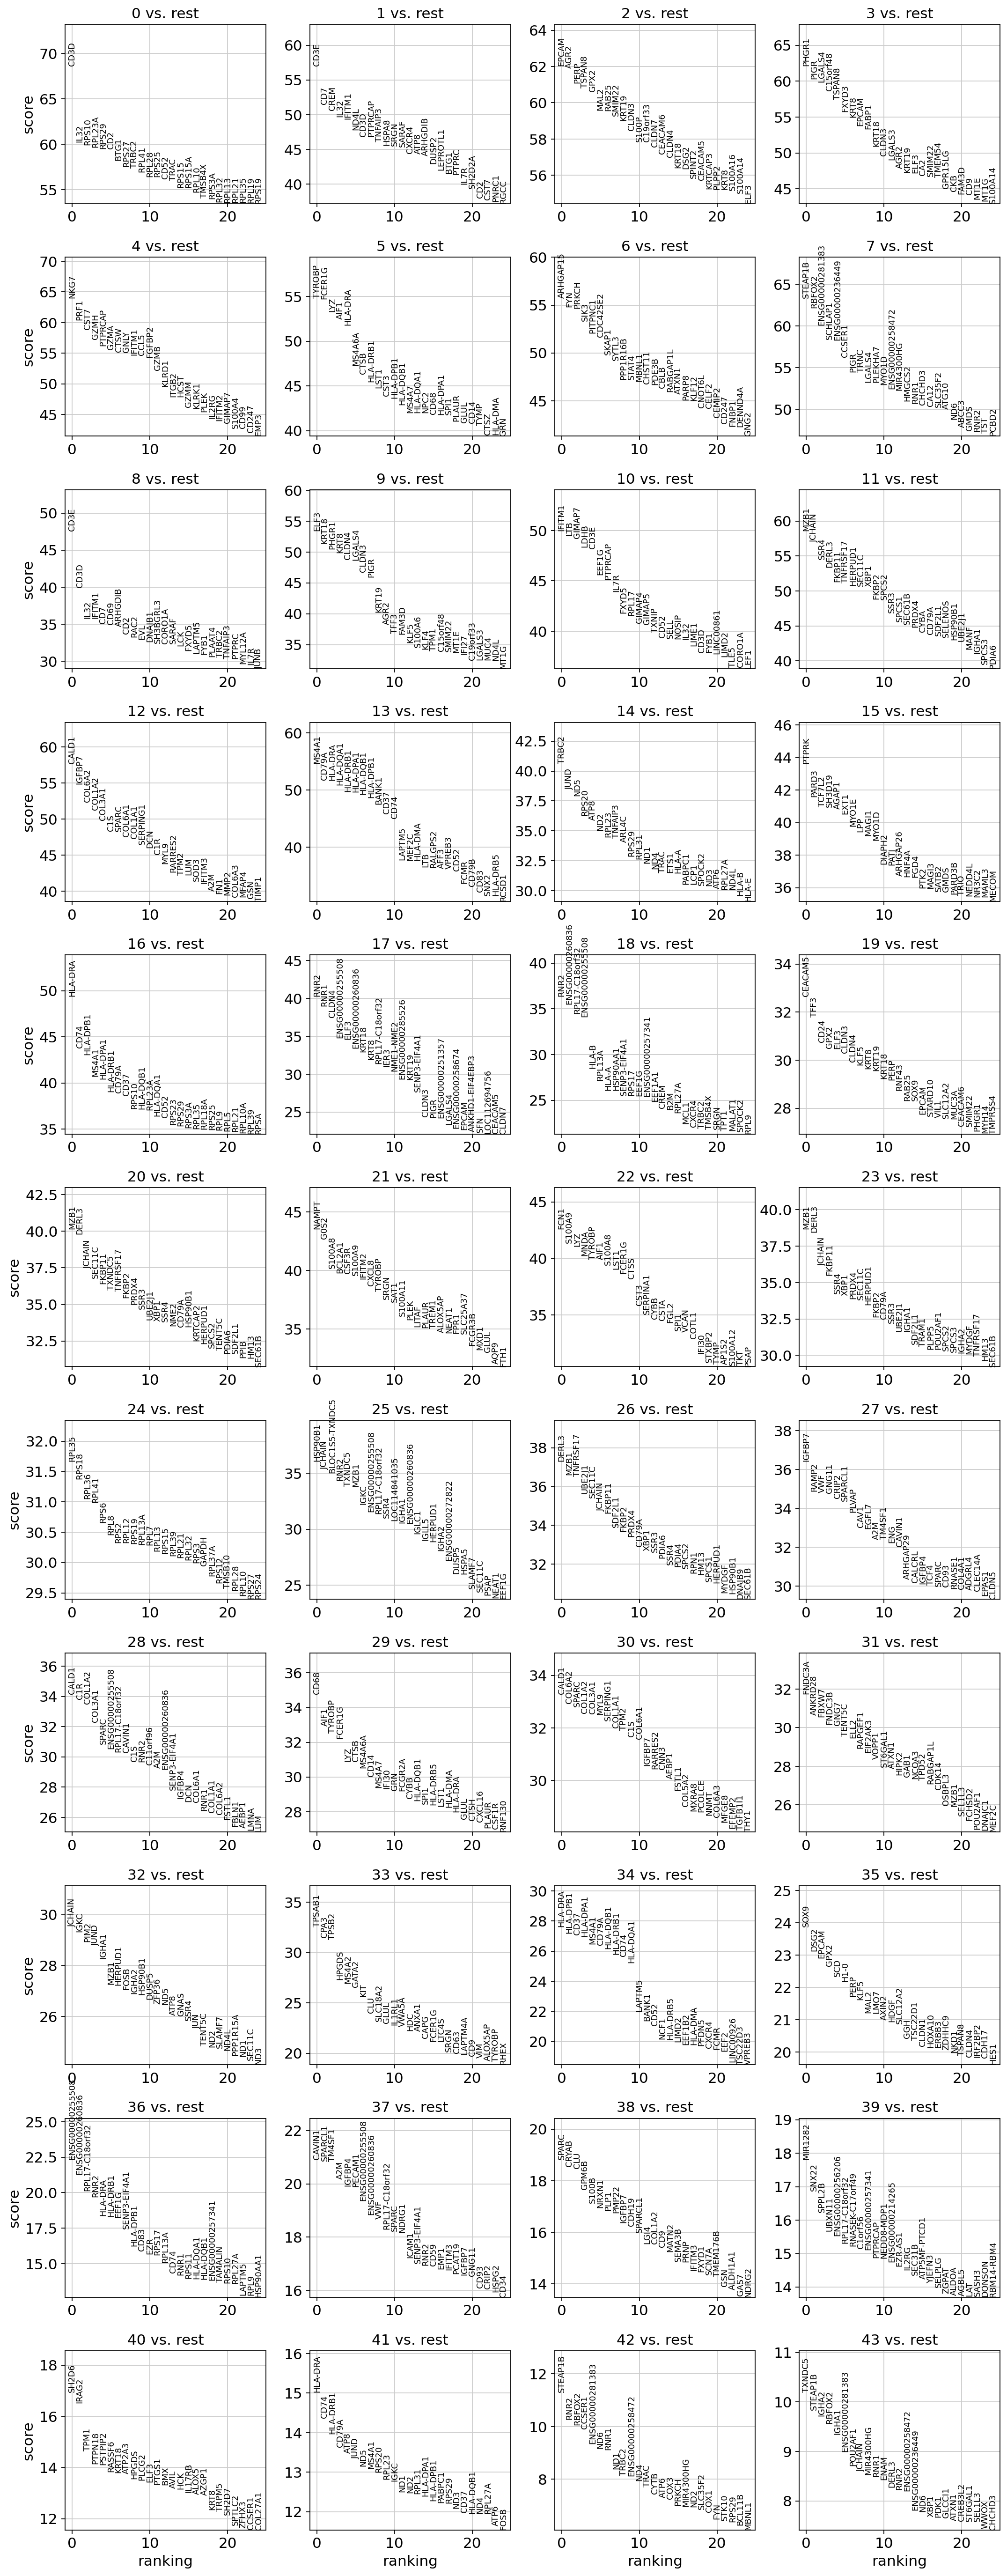

In [32]:
# --- 5단계: 차원 축소 (Dimensionality Reduction) - PCA ---
# 주성분 분석(PCA)을 수행하여 데이터의 주된 변동 축을 찾음
# n_comps: 사용할 주성분 개수. 보통 50개 정도 사용하나, elbow plot 보고 결정
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# PCA 결과 시각화 (elbow plot으로 사용할 PC 개수 결정에 도움)
sc.pl.pca(adata, color='CST3', show=True) # 예시 유전자로 색칠
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, show=True) # Elbow plot

# --- 6단계: 이웃 그래프 생성 (Neighborhood Graph) ---
# PCA 공간에서 각 세포의 가까운 이웃을 찾음 (K-Nearest Neighbors, KNN)
# n_neighbors: 각 세포마다 고려할 이웃 수
# n_pcs: 사용할 주성분(PC) 개수 (elbow plot 참고하여 결정)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

# --- 7단계: 클러스터링 (Clustering) ---
# 이웃 그래프를 기반으로 세포 군집화 (Leiden 알고리즘이 널리 사용됨)
# resolution: 클러스터 개수에 영향 (값이 크면 클러스터 수가 증가하는 경향)
sc.tl.leiden(adata, resolution=0.8, key_added="clusters_leiden")
# sc.tl.louvain(adata, resolution=0.8, key_added="clusters_louvain")

# --- 8단계: 시각화 (Visualization) - UMAP/t-SNE ---
# 고차원 데이터를 2차원으로 축소하여 시각화
# UMAP이 t-SNE보다 전역 구조를 더 잘 보존하고 계산 속도가 빠른 경향이 있음
sc.tl.umap(adata)
# sc.tl.tsne(adata, n_pcs=40) # 필요시 t-SNE도 계산 가능

# UMAP 결과 시각화 (Leiden 클러스터 또는 특정 유전자로 색칠)
sc.pl.umap(adata, color=['clusters_leiden', 'CST3', 'NKG7'], show=True) # 예시 유전자 포함

# --- (선택 사항) 클러스터 마커 유전자 찾기 ---
# 각 클러스터에서 특이적으로 발현되는 유전자(마커 유전자) 식별
# rank_genes_groups는 .raw 데이터를 사용함 (정규화+로그변환 데이터)
sc.tl.rank_genes_groups(adata, 'clusters_leiden', method='wilcoxon') # Wilcoxon 순위합 검정 사용
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, show=True)

# 결과 저장
adata.write('/data/kjc2/projects/P330.CSA/rds/downsampled_100_re_processed_log1p.h5ad')

### optional clusterings

In [ ]:
sc.tl.dbscan(adata, eps=0.5, min_samples=5, key_added="clusters_dbscan")

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0)
adata.obs['clutsers_kmeans'] = kmeans.fit_predict(adata.obsm['X_pca'])

from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(adata.obsm['X_pca'], method='ward')
adata.obs['clutsers_hierarchical'] = fcluster(Z, t=8, criterion='maxclust')

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', random_state=0)
adata.obs['clutsers_spectral'] = spectral.fit_predict(adata.obsm['X_pca'])

#?Phenograph

## contingency table

In [ ]:
import pandas as pd

# adata.obs에서 'seurat_clusters'와 'disease' 열을 사용하여 contingency table 생성
contingency_table = pd.crosstab(adata.obs['clusters_leiden'], adata.obs['disease'])
print(contingency_table)

# integration

## Harmony

In [44]:
import scanpy as sc
import scanpy.external as sce
import harmonypy
adata_merged=adata
# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별 및 스케일링 완료됨

# 1. PCA 수행
# sc.tl.pca(adata_merged)

# 2. Harmony 실행
# key: 배치 정보가 담긴 .obs 컬럼 이름
# basis: 입력으로 사용할 임베딩 (보통 'X_pca')
# adjusted_basis: Harmony로 보정된 임베딩이 저장될 이름 (예: 'X_pca_harmony')
sce.pp.harmony_integrate(adata_merged, key='dataset', basis='X_pca', adjusted_basis='X_pca_harmony')
# 2025-04-16 16:06:59,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
# 2025-04-16 16:07:02,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
# 2025-04-16 16:07:02,470 - harmonypy - INFO - Iteration 1 of 10
# 2025-04-16 16:07:16,329 - harmonypy - INFO - Iteration 2 of 10
# 2025-04-16 16:07:30,020 - harmonypy - INFO - Iteration 3 of 10
# 2025-04-16 16:07:43,172 - harmonypy - INFO - Iteration 4 of 10
# 2025-04-16 16:07:56,442 - harmonypy - INFO - Iteration 5 of 10
# 2025-04-16 16:08:09,667 - harmonypy - INFO - Iteration 6 of 10
# 2025-04-16 16:08:21,024 - harmonypy - INFO - Iteration 7 of 10
# 2025-04-16 16:08:32,705 - harmonypy - INFO - Converged after 7 iterations
# 3. 보정된 임베딩 사용
# 이웃 그래프 생성 시 'X_pca_harmony' 사용
sc.pp.neighbors(adata_merged, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after Harmony)', 'UMAP colored by cell type (after Harmony)'])

2025-04-16 16:06:59,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-16 16:07:02,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-16 16:07:02,470 - harmonypy - INFO - Iteration 1 of 10
2025-04-16 16:07:16,329 - harmonypy - INFO - Iteration 2 of 10
2025-04-16 16:07:30,020 - harmonypy - INFO - Iteration 3 of 10
2025-04-16 16:07:43,172 - harmonypy - INFO - Iteration 4 of 10
2025-04-16 16:07:56,442 - harmonypy - INFO - Iteration 5 of 10
2025-04-16 16:08:09,667 - harmonypy - INFO - Iteration 6 of 10
2025-04-16 16:08:21,024 - harmonypy - INFO - Iteration 7 of 10
2025-04-16 16:08:32,705 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


KeyError: 'batch'

<Figure size 772.8x320 with 0 Axes>

In [47]:
# sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after Harmony)', 'UMAP colored by cell type (after Harmony)'])
sc.pl.umap(adata_merged, color=['dataset'], title=['UMAP colored by cell type (after Harmony)'])
sc.pl.umap(adata_merged, color=['cell_type'], title=['UMAP colored by batch (after Harmony)'])

### saving

In [ ]:
import datetime
now = datetime.datetime.now()
now_format = now.strftime('%Y.%m.%d.%H%M%S')
print(now_format)
adata_merged.write_h5ad(f"/data/kjc2/projects/P330.CSA/rds/downsampled_100_re_processed_log1p_harmonized_{now_format}.h5ad")

## scvi

In [ ]:
import scanpy as sc
import scvi
adata_merged=adata
# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별됨 (scVI는 내부적으로 유전자를 다시 고려할 수 있음)
# 가정: 원시 카운트가 adata_merged.layers['counts']에 있음 (또는 .X가 카운트)

# 0. 원시 카운트 데이터가 있는지 확인 및 설정 (예시)
# if 'counts' not in adata_merged.layers:
#     # .raw 에서 가져오거나 다시 로드해야 할 수 있음
#     # 예시: adata_merged.layers['counts'] = adata_merged.raw.X.copy()
#     # 또는 처음부터 카운트 데이터를 .X에 유지하고 진행

# 1. scVI 모델 설정
# batch_key: 배치 정보 컬럼
# layer: 사용할 카운트 데이터 레이어 (None이면 .X 사용)
# scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='batch')
scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='batch')

# 2. 모델 생성 및 훈련
# n_latent: 잠재 공간 차원 수
model = scvi.model.SCVI(adata_merged, n_latent=30)
model.train() # GPU 사용 가능 시 자동으로 활용

# 3. 보정된 잠재 공간 얻기
adata_merged.obsm['X_scVI'] = model.get_latent_representation()

# 4. 보정된 임베딩 사용
# 이웃 그래프 생성 시 'X_scVI' 사용
sc.pp.neighbors(adata_merged, n_pcs=30, use_rep='X_scVI')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after scVI)', 'UMAP colored by cell type (after scVI)'])

# scVI는 보정된 정규화 값도 생성 가능 (선택적)
# adata_merged.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

## CCA - Scanorama

In [ ]:
import scanpy as sc
import scanpy.external as sce

# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별됨, 데이터는 정규화/로그변환/스케일링 됨

# 1. Scanorama 실행 (HVG 부분집합에 대해)
# batch_key: 배치 정보 컬럼
# batch_size: 메모리 사용량 조절 (데이터 크기에 따라 조절)
adata_hvg = adata_merged[:, adata_merged.var.highly_variable].copy()
sce.pp.scanorama_integrate(adata_hvg, key='batch', basis='X', adjusted_basis='X_scanorama')

# Scanorama는 PCA 공간에서도 수행 가능
# sc.tl.pca(adata_hvg)
# sce.pp.scanorama_integrate(adata_hvg, key='batch', basis='X_pca', adjusted_basis='X_pca_scanorama')

# 2. 보정된 결과 사용
# Scanorama가 보정한 값은 원래 AnnData 객체의 HVG에 해당하는 부분에 다시 넣거나,
# 보정된 PCA를 사용할 수 있습니다. 여기서는 보정된 발현값 예시.
# 주의: Scanorama는 HVG만 보정하므로, 전체 유전자가 필요하면 주의해야 함.
# 보통 보정된 값을 기반으로 PCA를 다시 계산하고 진행합니다.

# 보정된 값을 원래 adata에 반영 (주의: HVG만 업데이트됨)
adata_merged.obsm['X_scanorama'] = adata_hvg.obsm['X_scanorama'] # 보정된 데이터 (세포 x 유전자)

# 보정된 데이터로 PCA 다시 수행 (선택적 접근)
# PCA를 보정한 경우:
# sc.pp.neighbors(adata_hvg, n_pcs=30, use_rep='X_pca_scanorama')
# sc.tl.umap(adata_hvg)
# sc.pl.umap(adata_hvg, color=['batch', 'cell_type'], title=['UMAP colored by batch (after Scanorama PCA)', 'UMAP colored by cell type (after Scanorama PCA)'])

# 발현 행렬을 보정한 경우 (보정된 값으로 PCA/Neighbors 진행):
# 이 방식은 덜 일반적일 수 있음. 보통 보정된 PCA나 scVI/Harmony latent 사용.
sc.pp.neighbors(adata_merged, use_rep='X_scanorama') # 보정된 HVG 발현값 기반 이웃 찾기
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['batch', 'cell_type'], title=['UMAP colored by batch (after Scanorama expression)', 'UMAP colored by cell type (after Scanorama expression)'])

# merging

In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd

# --- 예시 데이터 생성 ---
# 실제로는 sc.read_10x_mtx, sc.read_h5ad 등으로 로드합니다.
adata_A = ad.AnnData(X=np.random.rand(100, 500),
                     obs=pd.DataFrame({'batch_orig': ['A1'] * 50 + ['A2'] * 50}, index=[f'A_cell_{i}' for i in range(100)]),
                     var=pd.DataFrame(index=[f'Gene_{i}' for i in range(500)]))
adata_B = ad.AnnData(X=np.random.rand(150, 600),
                     obs=pd.DataFrame({'batch_orig': ['B1'] * 70 + ['B2'] * 80}, index=[f'B_cell_{i}' for i in range(150)]),
                     var=pd.DataFrame(index=[f'Gene_{i}' for i in range(150, 750)])) # 유전자 일부 겹치고 일부 다름

print("A data:", adata_A)
print("B data:", adata_B)

# --- AnnData 객체 합치기 ---
# join='inner': 두 데이터셋에 공통으로 존재하는 유전자만 유지
# join='outer': 모든 유전자를 유지하고, 없는 경우 0으로 채움 (메모리 주의)
# batch_key: 합쳐진 AnnData의 .obs에 추가될 컬럼 이름 (어떤 원본 데이터에서 왔는지 표시)
# batch_categories: batch_key 컬럼에 들어갈 값 (원본 데이터셋 이름 지정)
# index_unique: 세포 ID가 겹칠 경우 고유하게 만들기 위해 접미사 추가 (예: '-A', '-B')
adata_merged = adata_A.concatenate(adata_B,
                                  join='inner', # 공통 유전자만 사용
                                  batch_key='dataset_source',
                                  batch_categories=['SetA', 'SetB'],
                                  index_unique=None) # 세포 ID가 원래 고유하다면 None

print("\nMerged data:", adata_merged)
print("\nMerged obs head:\n", adata_merged.obs.head())
print("\nMerged obs tail:\n", adata_merged.obs.tail())
print("\nUnique dataset sources:", adata_merged.obs['dataset_source'].unique())

## new batch key

In [ ]:
# 가정: 'adata_merged'는 위 2번에서 생성된 합쳐진 객체
# 'dataset_source' 컬럼과 'batch_orig' 컬럼이 .obs에 존재

# 1. 두 컬럼을 문자열로 변환하여 합치기
adata_merged.obs['integrated_batch'] = adata_merged.obs['dataset_source'].astype(str) + '_' + \
                                       adata_merged.obs['batch_orig'].astype(str)

# 2. 결과 확인
print("\nObs with new integrated batch key:\n", adata_merged.obs.head())
print("\nUnique integrated batch keys:", adata_merged.obs['integrated_batch'].unique())

# 이제 'integrated_batch' 컬럼을 위 1번의 integration 메소드들의 'key' 파라미터로 사용할 수 있습니다.
# 예: sce.pp.harmony_integrate(adata_merged, key='integrated_batch', ...)
# 예: scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='integrated_batch')